In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/playoff_per_game_2013-22.csv')
pred_data = pd.read_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/team_per_game_2023.csv')
data

,Unnamed: 0,Team,Year,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Attend.,Attend./G,Playoff_W,Payroll,Adjusted Payroll
0,0,Denver Nuggets,2013,40.7,85.2,0.478,6.4,18.5,0.343,34.4,...,0.216,0.493,14.3,71.8,0.193,730616.0,17820.0,2.0,63444254,172431.041284
1,1,Houston Rockets,2013,38.1,82.7,0.461,10.6,28.9,0.366,27.5,...,0.232,0.502,13.5,75.2,0.196,683564.0,16672.0,2.0,48048265,130587.276916
2,2,Oklahoma City Thunder,2013,38.1,79.3,0.481,7.3,19.4,0.377,30.8,...,0.280,0.469,13.5,73.4,0.197,746323.0,18203.0,5.0,68924100,187324.360888
3,3,San Antonio Spurs,2013,39.1,81.4,0.481,8.1,21.5,0.376,31.1,...,0.204,0.480,13.7,74.9,0.179,755700.0,18432.0,15.0,69838600,189809.821387
4,4,Miami Heat,2013,38.4,77.4,0.496,8.7,22.1,0.396,29.6,...,0.224,0.487,14.8,73.0,0.200,819290.0,19983.0,16.0,80427933,218589.885784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,Golden State Warriors,2022,40.5,86.4,0.469,14.3,39.4,0.364,26.2,...,0.181,0.509,13.0,78.7,0.201,740624.0,18064.0,16.0,178980766,349607.695551
151,151,Miami Heat,2022,39.6,84.8,0.467,13.6,35.8,0.379,26.0,...,0.204,0.524,13.8,78.0,0.209,804761.0,19628.0,11.0,140840240,275106.833252
152,152,Philadelphia 76ers,2022,39.4,84.5,0.466,11.6,31.8,0.364,27.8,...,0.232,0.524,12.1,76.8,0.192,846867.0,20655.0,6.0,148922969,290895.033976
153,153,Toronto Raptors,2022,40.6,91.3,0.445,11.9,34.2,0.349,28.7,...,0.177,0.535,14.4,75.6,0.199,547343.0,13350.0,2.0,134896484,263496.743047


In [3]:
# creating list of variables conditioning upon a correlation coefficient of above 0.25 with playoff wins, our 
# indepentent variable
corr = data.corr().abs()
corr = corr.loc[corr['Playoff_W']>.25]
corr.index
variables = list(corr.index)

In [4]:
variables

['FG%',
 '3P%',
 '2P%',
 'AST',
 'W',
 'MOV',
 'SRS',
 'ORtg',
 'NRtg',
 'TS%',
 'eFG%',
 'Playoff_W']

<AxesSubplot:title={'center':'Correlation between Filtered Variables'}>

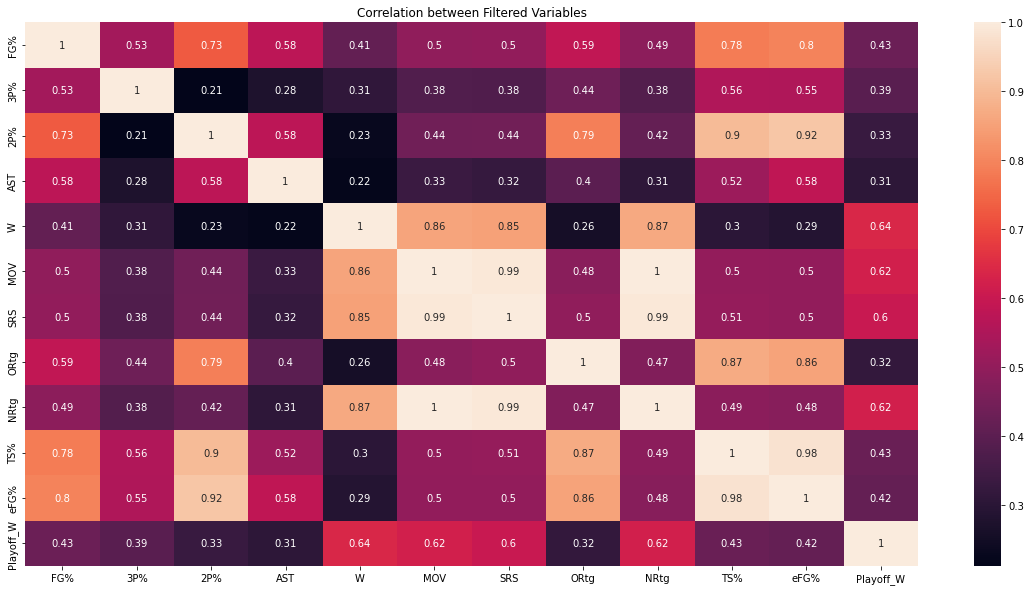

In [5]:
plt.figure(figsize=(20,10))
plt.title("Correlation between Filtered Variables")
sns.heatmap(data=data[variables].corr(), annot=True)

In [15]:
var_heatmap = variables.copy()
var_heatmap.append('Adjusted Payroll')
df_correlations = data[var_heatmap].corr().reset_index(level=0).rename(columns={"Playoff_W": "P_W", "Adjusted Payroll": "Pay"}).replace({"Playoff_W": "P_W", "Adjusted Payroll": "Pay"})

df_correlations = df_correlations.melt('index', var_name='Variable', value_name='Correlation')
df_correlations.to_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/correlations_playoff.csv')

In [ ]:
corr_pay = data['Playoff_W'].corr(data['Adjusted Payroll'])
corr_wins = data['W'].corr(data['Adjusted Payroll'])

print(f'Correlation between playoff wins and payrolls: {corr_pay}')
print(f'Correlation between regular season wins and payrolls: {corr_wins}')

In [ ]:
# removing MOV (margin of victory) as this variable causes multicolinearity concerns with SRS (Simple Rating System)
# additionally, removing Adjusted Payroll given we do not want payroll to factor into the linear regression when
# comparing predicted playoff rating with payrolls
remove = ['MOV','Adjusted Payroll']
variables = [item for item in variables if item not in remove]
variables

In [ ]:
# creating our coefficient matrices
X = data[variables].drop('Playoff_W',1)
Y = data['Playoff_W']

pred_X = pred_data[variables].drop('Playoff_W',1)

X.head()

In [ ]:
# creating our test split, with a size of 20% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# training our model
model = LinearRegression().fit(X_train, Y_train)
model_predicted_wins = model.predict(X_test)

In [ ]:
# explore model performance
print('Coefficients: ', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared erorr: %.2f' 
    % mean_squared_error(Y_test, model_predicted_wins))
print('Coefficient of determination (R^2): %.2f' 
    % r2_score(Y_test, model_predicted_wins))

In [ ]:
# scatter plot of our predicted playoff wins vs actual playoff wins
sns.scatterplot(Y_test, model_predicted_wins)

In [ ]:
# defining the linear regression model
model_predicted_wins = model.predict(pred_X)

# normalizing the predicted playoff wins, to prevent teams being predicted "negative wins" due to the fact the 2022/23
# season has yet to end (in addition to aiding interpretation)
w_min, w_max = min(model_predicted_wins), max(model_predicted_wins)
for i, win in enumerate(model_predicted_wins):
    model_predicted_wins[i] = (win-w_min) / (w_max - w_min)

model_predicted_wins

In [ ]:
# creating DataFrame of normalized predicted playoff wins (so-called predicted playoff rating) for 2022/23 season
model_predicted_wins_df = pred_data[['Team','Playoff_W']]
 
for i in range(30):
    model_predicted_wins_df.loc[i, 'Playoff_W'] = model_predicted_wins[i]

model_predicted_wins_df = model_predicted_wins_df.sort_values(by='Playoff_W',ascending=False).reset_index(drop=True)
model_predicted_wins_df = model_predicted_wins_df.rename(columns={'Playoff_W': 'Predicted Playoff Rating'})
model_predicted_wins_df

In [ ]:
# merging predicted playoff wins DataFrame with Payroll data for comparison
payroll = pred_data[['Team', 'Payroll']]
model_predicted_wins_df = pd.merge(model_predicted_wins_df, payroll, on='Team')
model_predicted_wins_df

In [ ]:
model_predicted_wins_df.to_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/model_predicted_wins.csv')

In [ ]:
corr_pred = model_predicted_wins_df['Predicted Playoff Rating'].corr(model_predicted_wins_df['Payroll'])
print(f'Correlation between predicted win rating and payrolls: {corr_pred}')

In [ ]:
ax = model_predicted_wins_df.plot.barh(x='Team', y='Predicted Playoff Rating', figsize=(10,10))

In [ ]:
fig = ax.get_figure()
fig.savefig('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/figures/win_rating_bar.jpeg')